# Test of bespoke neural network

Import necessary modules:

In [ ]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string,
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model,
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.quantum = False
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20250502-11-55-56 - 11-55-56


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\four_d.txt.
It is known that the shortest distance is 21


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl.locations, 
                       distance_array, 
                       sdl.gray, 
                       method = sdl.formulation, 
                       )
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 5 qubits needed for 4 locations in the new formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [ ]:
if sdl.hot_start:
    hot_start_list = hot_start(distance_array, sdl.locations)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                                sdl.locations, 
                                                sdl.gray, 
                                                sdl.formulation,
                                                )
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    sdl.hot_start_dist = float(distance_tensor)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    if sdl.mode == 8:
        #input is all zeros
        unrepeated_input = torch.full((1,sdl.qubits), 0).float().to(device)
    elif sdl.mode == 9:
        #input is 0.5
        unrepeated_input = torch.full((1,sdl.qubits), 0.5).float().to(device)

    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)

In [9]:
unrepeated_input.size()

torch.Size([1, 5])

In [10]:
print(unrepeated_input.size())

torch.Size([1, 5])


Set up model with gradient required:

In [11]:
model = MyModel(sdl.qubits, 
                sdl.layers, 
                sdl.std_dev, 
                cost_fn,
                sdl.hot_start,
                ).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 120 parameters in total, of which 120 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True
Parameter fc3.weight requires_grad: True
Parameter fc3.bias requires_grad: True
Parameter fc4.weight requires_grad: True
Parameter fc4.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

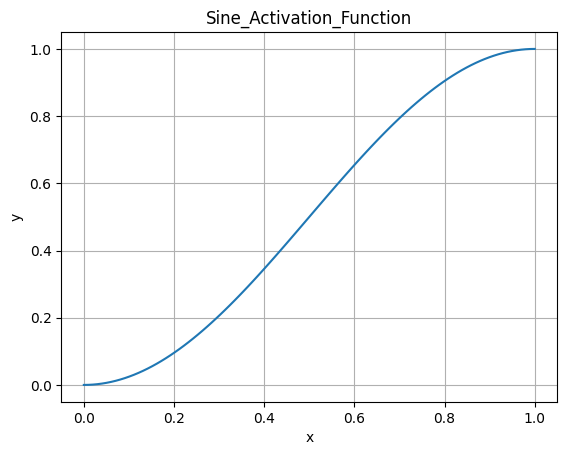

In [13]:
plot_sine_activation()

Print out model details including graph

factorial f = 24, bit_string = [0, 0, 0, 1, 1]
start_cycle_list = [0, 1, 2, 3]
end_cycle_list = []
Starting loop with i = 0 y = 3 f=24
factorial f = 6
k = 0
start_cycle_list = [1, 2, 3]
end_cycle_list = [0]
Starting loop with i = 1 y = 3 f=6
factorial f = 2
k = 1
start_cycle_list = [1, 3]
end_cycle_list = [0, 2]
Starting loop with i = 2 y = 1 f=2
factorial f = 1
k = 1
start_cycle_list = [1]
end_cycle_list = [0, 2, 3]
Starting loop with i = 3 y = 0 f=1
factorial f = 1
k = 0
start_cycle_list = []
end_cycle_list = [0, 2, 3, 1]
factorial f = 24, bit_string = [0, 0, 0, 0, 0]
start_cycle_list = [0, 1, 2, 3]
end_cycle_list = []
Starting loop with i = 0 y = 0 f=24
factorial f = 6
k = 0
start_cycle_list = [1, 2, 3]
end_cycle_list = [0]
Starting loop with i = 1 y = 0 f=6
factorial f = 2
k = 0
start_cycle_list = [2, 3]
end_cycle_list = [0, 1]
Starting loop with i = 2 y = 0 f=2
factorial f = 1
k = 0
start_cycle_list = [3]
end_cycle_list = [0, 1, 2]
Starting loop with i = 3 y = 0 f=1
factorial f = 

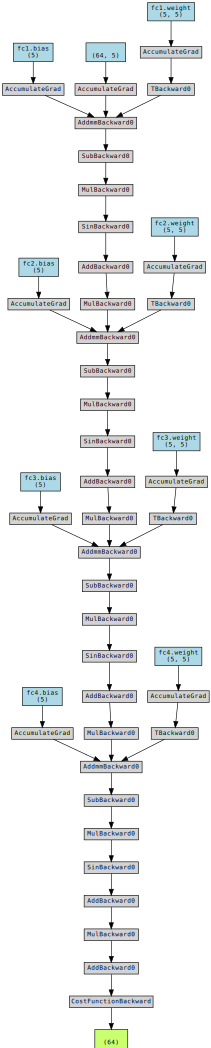

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

factorial f = 24, bit_string = [1, 1, 1, 0, 0]
start_cycle_list = [0, 1, 2, 3]
end_cycle_list = []
Starting loop with i = 0 y = 4 f=24
factorial f = 6
k = 0
start_cycle_list = [1, 2, 3]
end_cycle_list = [0]
Starting loop with i = 1 y = 4 f=6
factorial f = 2
k = 2
start_cycle_list = [1, 2]
end_cycle_list = [0, 3]
Starting loop with i = 2 y = 0 f=2
factorial f = 1
k = 0
start_cycle_list = [2]
end_cycle_list = [0, 3, 1]
Starting loop with i = 3 y = 0 f=1
factorial f = 1
k = 0
start_cycle_list = []
end_cycle_list = [0, 3, 1, 2]
factorial f = 24, bit_string = [1, 1, 1, 1, 0]
start_cycle_list = [0, 1, 2, 3]
end_cycle_list = []
Starting loop with i = 0 y = 6 f=24
factorial f = 6
k = 1
start_cycle_list = [0, 2, 3]
end_cycle_list = [1]
Starting loop with i = 1 y = 0 f=6
factorial f = 2
k = 0
start_cycle_list = [2, 3]
end_cycle_list = [1, 0]
Starting loop with i = 2 y = 0 f=2
factorial f = 1
k = 0
start_cycle_list = [3]
end_cycle_list = [1, 0, 2]
Starting loop with i = 3 y = 0 f=1
factorial f = 

In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 21.000 at epoch 0.
The best known cost is 21.000


Plot loss ratio by epoch:

Graph for Run ID: 20250502-11-55-56-11-55-56 being saved to graphs\20250502-11-55-56\11-55-56.png


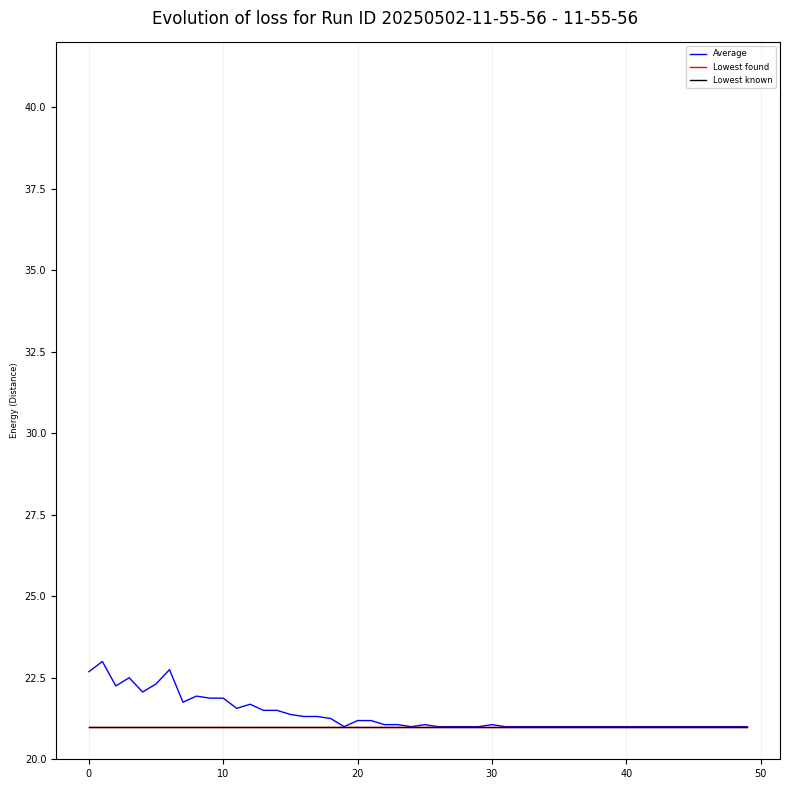

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[-0.2086, -0.1531,  0.2819,  0.3490, -0.3407],
        [ 0.3971, -0.4003, -0.0810, -0.2689,  0.4450],
        [ 0.3590, -0.2374,  0.1944, -0.1146, -0.1606],
        [-0.3227, -0.3287,  0.2970, -0.1427,  0.3842],
        [ 0.3971, -0.1873, -0.3572, -0.2857, -0.0869]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
tensor([-0.0636,  0.3541,  0.3941,  0.0536, -0.3175], device='cuda:0',
       requires_grad=True)
weight: Parameter containing:
tensor([[ 0.0585, -0.1872,  0.1226,  0.3552,  0.1565],
        [ 0.0074,  0.2962, -0.4218, -0.1844, -0.2630],
        [-0.2289,  0.4464,  0.1470, -0.2372, -0.3553],
        [ 0.1742,  0.0207,  0.1074,  0.3119,  0.3129],
        [ 0.1857, -0.4514,  0.0193,  0.2555, -0.1893]], device='cuda:0',
       requires_grad=True)
bias: Parameter containing:
tensor([-0.0417,  0.1894,  0.0062, -0.3148,  0.2025], device='cuda:0',
       requires_grad=True)
weight: Parameter containing:
tensor([[ 0.1896, 